#### Dependencies
- numpy
- pandas
- scipy
- matplotlib
- utide

In [39]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.fft as fft

from utide import solve, reconstruct

C:\Users\Lachlan D-K\Documents\Github\ph3080-moon-wobble-challenge\venv\lib\site-packages\pandas\io\parsers\base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


10 points were flagged "bad" and interpolated
212 points were flagged "corrected" and left unchanged
solve: matrix prep ... solution ... done.
prep/calcs ... done.


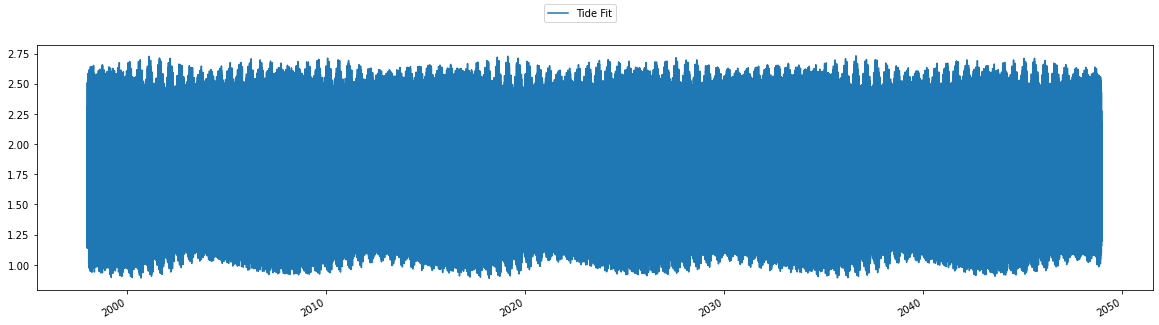

In [107]:
# parse dataframe file
# mostly reuses code from utide examples

def date_parser(year, month, day, hour):
    year, month, day, hour = map(int, (year, month, day, hour))
    return datetime.datetime(year, month, day, hour)

parse_dates = dict(datetime=["year", "month", "day", "hour"])
names = ["year", "month", "day", "hour", "height", "flag"]

observations = pd.read_table("utide_test_data.dtf",
                    names=names,
                    skipinitialspace=True,
                    delim_whitespace=True,
                    index_col="datetime",
                    usecols=range(1, 7),
                    parse_dates=parse_dates,
                    date_parser=date_parser)

bad = observations["flag"] == 2
corrected = observations["flag"] == 1

observations.loc[bad, "height"] = np.nan
observations["height"].interpolate()
print(f"{bad.sum()} points were flagged \"bad\" and interpolated")
print(f"{corrected.sum()} points were flagged \"corrected\" and left unchanged")

datenums = dates.date2num(observations.index.to_pydatetime())  # convert index to datenum (days since jan 1st 1970)
sol = solve(datenums, observations["height"].values,
            lat=-25,
            nodal=True,
            trend=False,
            conf_int="MC")

# extrapolate observed tides
years = 50  # how many years to predict
hour_delta = datetime.timedelta(hours=1)
extrap_datenums = observations.index.union(pd.date_range(observations.index[-1] + hour_delta, periods=365.25 * 24 * years, freq=hour_delta)).to_pydatetime()
extrap_times = dates.date2num(extrap_datenums)

tide_model = reconstruct(extrap_times, sol)
tide_data = np.array([tide_model.t_mpl, tide_model.h])

# Plot the extrapolated tide model
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(tide_data[0], tide_data[1], label="Tide Fit")
ax.xaxis_date()
fig.legend(loc="upper center")
fig.autofmt_xdate()

# Remove the effects of Moon Wobble

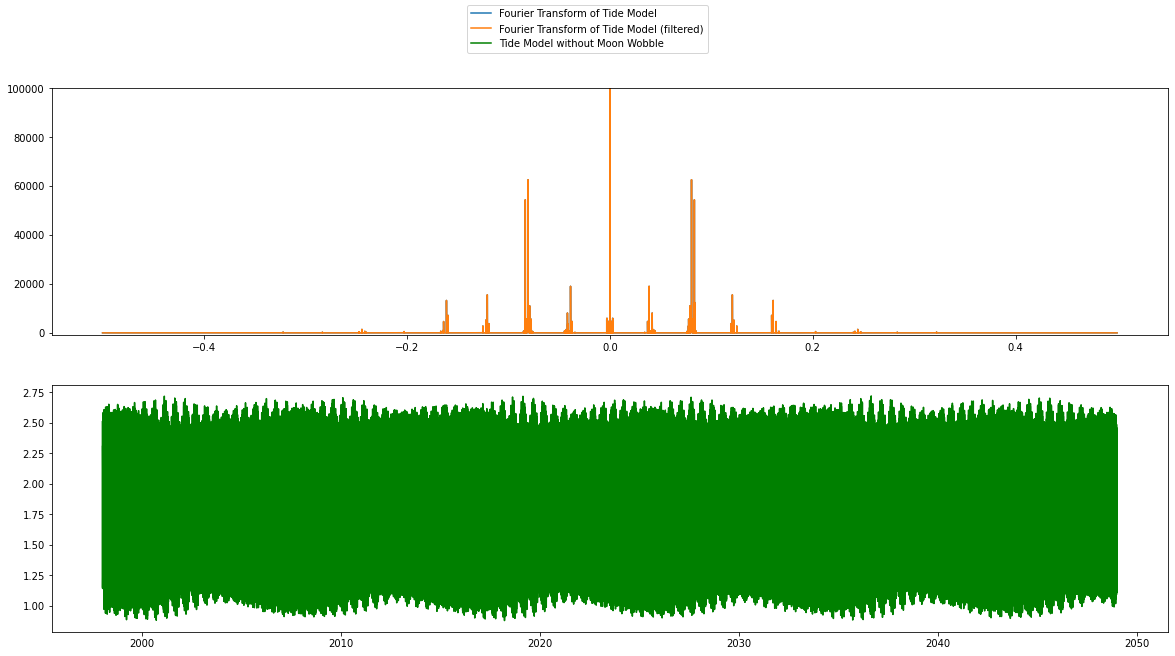

In [119]:
tide_heights_FFT = fft.fft(tide_data[1])
tide_freqs = fft.fftfreq(len(tide_data[1]))

freq = 1 / (18.61 * 365.25)  # moon wobble frequency ~1.5e-4 / day
moon_wobble_filter = (tide_freqs < - (freq + 0.0001)) + (tide_freqs > - (freq - 0.0001)) + (tide_freqs > freq - 0.0001) + (tide_freqs > freq + 0.0001)
filtered_tide_heights_FFT = tide_heights_FFT * moon_wobble_filter

filtered_tide_heights = np.real(fft.ifft(filtered_tide_heights_FFT))

# Plot the fourier transform and filtered data
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(fft.fftshift(tide_freqs), fft.fftshift(np.abs(tide_heights_FFT)), label="Fourier Transform of Tide Model")
ax1.plot(fft.fftshift(tide_freqs), fft.fftshift(np.abs(filtered_tide_heights_FFT)), label="Fourier Transform of Tide Model (filtered)")
ax1.set_ylim(-1000, 100000)

ax2.plot(tide_data[0], filtered_tide_heights, color="green", label="Tide Model without Moon Wobble")
ax2.xaxis_date()

fig.legend(loc="upper center")

# Simulate Sea-level Rise

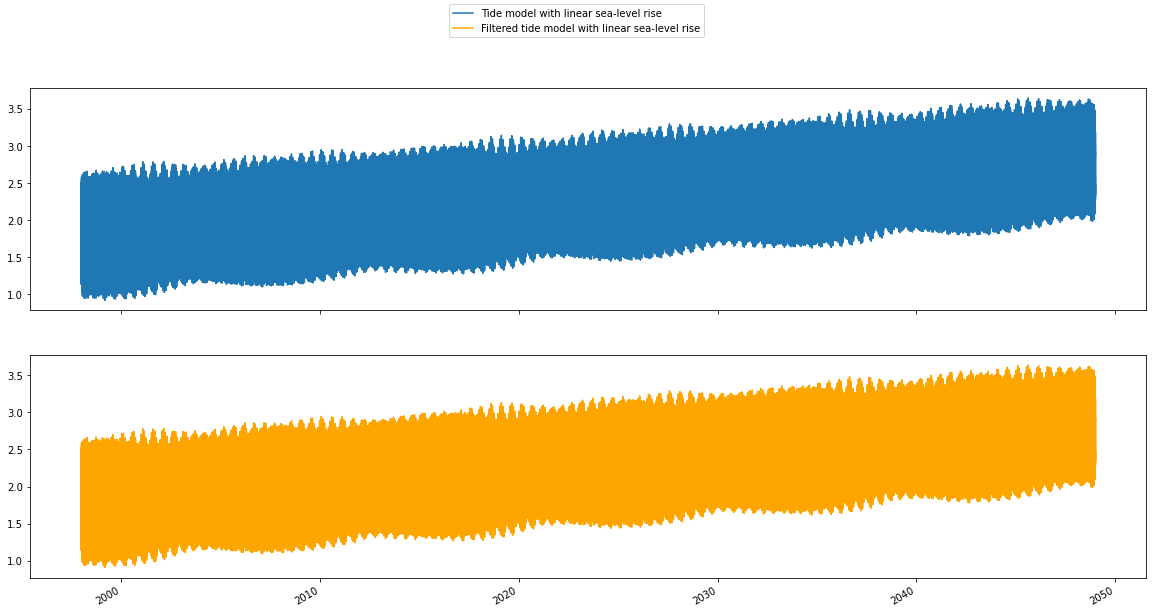

In [120]:
total_rise = 1

# linear rise, y = mx
sea_level = np.linspace(0, 1, len(tide_data[1]))

new_tide_heights = tide_data[1] + sea_level
filtered_new_tide_heights = filtered_tide_heights + sea_level

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex="all", figsize=(20, 10))

ax1.plot(tide_data[0], new_tide_heights, label="Tide model with linear sea-level rise")
ax1.xaxis_date()

ax2.plot(tide_data[0], filtered_new_tide_heights, label="Filtered tide model with linear sea-level rise", color="orange")
ax2.xaxis_date()

fig.legend(loc='upper center')
fig.autofmt_xdate()

# Calculate Frequency of High-tide Flooding

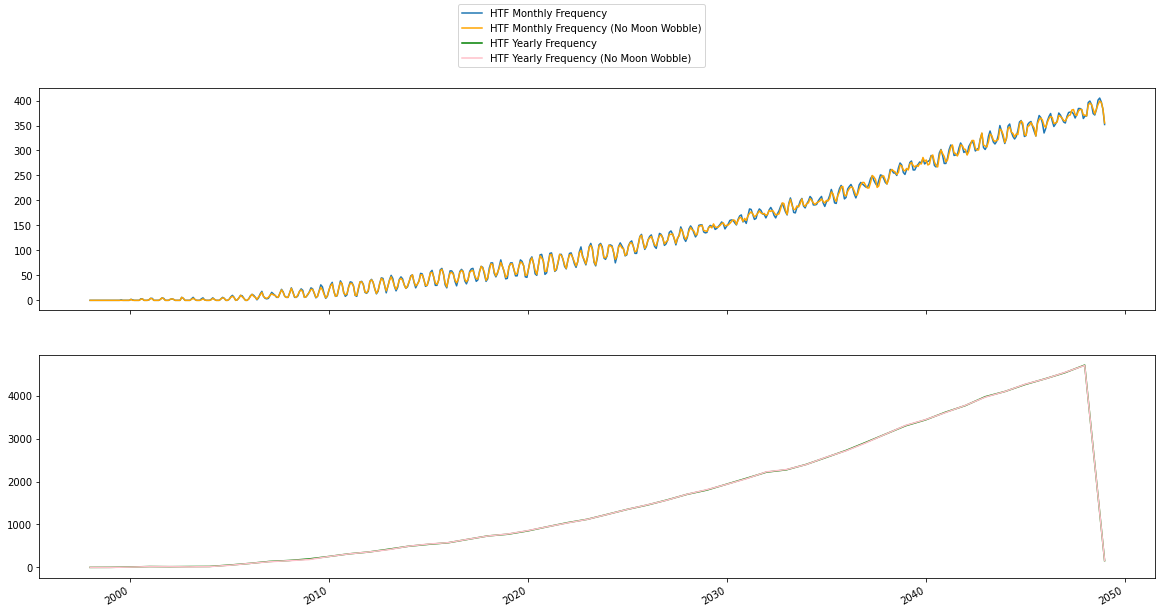

In [121]:
HTF_threshold = 2.7

# calculate the counts in a set window for which at least one hourly sea level measurement exceeds HTF threshold

def calculate_HTF_monthly_freq(heights):
    HTF_monthly_frequency = []
    hours_in_month = 30 * 24  # skewed, not every month is 30 days dwadawda
    for month_index in range(0, len(heights), hours_in_month):
        HTF_monthly_frequency.append(0)
        for hour_index in range(month_index, month_index + hours_in_month):
            if hour_index >= len(heights):
                break
            if heights[hour_index] >= HTF_threshold:
                HTF_monthly_frequency[-1] += 1
    return np.linspace(tide_data[0][0], tide_data[0][-1], len(HTF_monthly_frequency)), HTF_monthly_frequency  # TODO: this is also not correct ADWAWDWAD

def calculate_HTF_yearly_freq(heights):
    HTF_yearly_frequency = []
    hours_in_year = 365 * 24
    for year_index in range(0, len(heights), hours_in_year):
        HTF_yearly_frequency.append(0)
        for hour_index in range(year_index, year_index + hours_in_year):
            if hour_index >= len(heights):
                break
            if heights[hour_index] >= HTF_threshold:
                HTF_yearly_frequency[-1] += 1
    return np.linspace(tide_data[0][0], tide_data[0][-1], len(HTF_yearly_frequency)), HTF_yearly_frequency  # TODO: this is also not correct WADAWDVAW

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex="all", figsize=(20, 10))

months, monthly_freqs = calculate_HTF_monthly_freq(new_tide_heights)
_, filtered_monthly_freqs = calculate_HTF_monthly_freq(filtered_new_tide_heights)
ax1.plot(months, monthly_freqs, label="HTF Monthly Frequency")
ax1.plot(months, filtered_monthly_freqs, label="HTF Monthly Frequency (No Moon Wobble)", color="orange")
ax1.xaxis_date()

years, yearly_freqs = calculate_HTF_yearly_freq(new_tide_heights)
_, filtered_yearly_freqs = calculate_HTF_yearly_freq(filtered_new_tide_heights)
ax2.plot(years, yearly_freqs, label="HTF Yearly Frequency", color="green")
ax2.plot(years, filtered_yearly_freqs, label="HTF Yearly Frequency (No Moon Wobble)", color="pink")
ax2.xaxis_date()

fig.legend(loc='upper center')
fig.autofmt_xdate()